<a href="https://colab.research.google.com/github/lustea0201/Interpretability/blob/master/SHAPLEY_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting the outputs of the model on the noisy version of the third dataset



In [49]:
#@title
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive/')

!pip install flashtorch
from flashtorch.saliency import Backprop

!pip install shap 
import shap

torch.manual_seed(0)

dtype = torch.float

FIGSIZE = (6,5)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Now, we need to redefine the model, so that we can compute a saliency map for an input image. Then, we also want to load the state_dict of the trained model. 

In [50]:
#@title
class Net(nn.Module):
  
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5)
    self.pool1 = nn.MaxPool2d(kernel_size = 2)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 4)
    self.pool2 = nn.MaxPool2d(kernel_size = 5)
    self.fc1 = nn.Linear(in_features = 16*9*11, out_features = 120)
    self.fc2 = nn.Linear(in_features = 120, out_features = 84)
    self.fc3 = nn.Linear(in_features = 84, out_features = 2)
    self.drop = nn.Dropout(p = 0.5)
  

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = x.view(-1, self.num_flat_features(x)) # 16*9*11
    x = self.drop(F.relu(self.fc1(x)))
    x = self.drop(F.relu(self.fc2(x)))
    x = self.fc3(x)
    return x
  
  def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features


net = Net() # Model instantiation
# Loading the trained dictionnary state
net.load_state_dict(torch.load('drive/My Drive/Interpretability/model3_noisy.pth')) 

<All keys matched successfully>

Now, load and format the images we want to test the network's decision on. 

In [0]:
#@title
transf = transforms.Compose( [ToTensor(), 
                                  Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

im = ImageFolder(root = "/content/drive/My Drive/Interpretability/img4saliencymap/noisy_3", transform = transf)
batch_Size = 2
dataloader = DataLoader(im, batch_size = batch_Size, shuffle = False, num_workers = 0)
data = iter(dataloader)
images, labels = next(data)

idx_to_class = {j:i for i,j in im.class_to_idx.items()}

Let's import an image with label 0. 

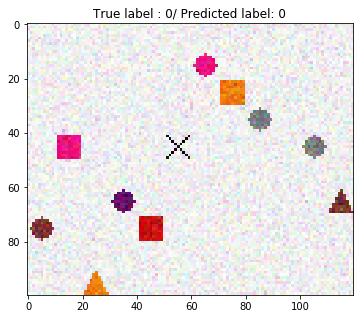

In [52]:
#@title
image0 = images[0]
label0 = labels[0]

im0 = image0.view(-1, 3, 100, 120) # This shape is necessary for the network 

outputs = net(im0)

_, predicted0 = torch.max(outputs.data, 1)

def display_image(image, true_label, predicted_label = None): 
  plt.figure(figsize = FIGSIZE)
  sample_image = image.numpy().transpose(1,2,0)
  mean = np.array([0.5, 0.5, 0.5])
  sd = np.array([0.5, 0.5, 0.5])
  im = sample_image*sd + mean
  plt.imshow(im)
  title_ = "True label : " + idx_to_class[int(true_label)]
  
  if (predicted_label != None):
    title_ += "/ Predicted label: " + idx_to_class[predicted_label]

  plt.title(title_)

display_image(image0, label0, int(predicted0))

This image was correctly labeled as a 0, because it doesn't contain any red triangles. 

What parts in the input were considered important by the network to make this call ? 

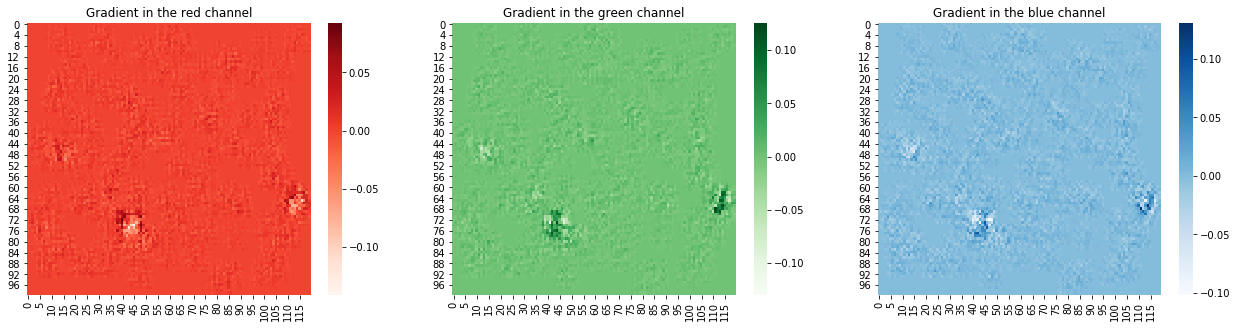

In [53]:
#@title
im0.requires_grad = True # Otherwise we can't compute the gradient 
backprop = Backprop(net)
gradients0 = backprop.calculate_gradients(im0, label0)

fig = plt.figure(figsize = (3*FIGSIZE[0]*1.2, FIGSIZE[1]))
ax1 = fig.add_subplot(131, title = "Gradient in the red channel")
ax2 = fig.add_subplot(132, title = "Gradient in the green channel")
ax3 = fig.add_subplot(133, title = "Gradient in the blue channel")
_ = sns.heatmap(gradients0.detach().numpy()[0], cmap="Reds", ax = ax1)
_ = sns.heatmap(gradients0.detach().numpy()[1], cmap="Greens", ax = ax2)
_ = sns.heatmap(gradients0.detach().numpy()[2], cmap="Blues", ax = ax3)

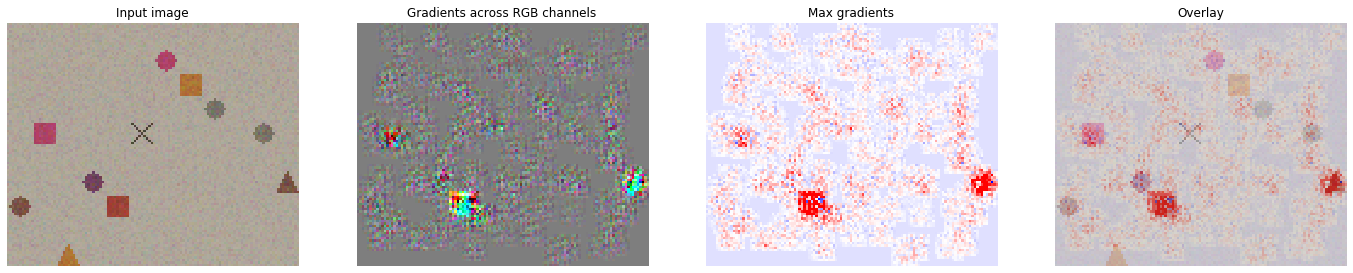

In [54]:
#@title
backprop.visualize(im0, label0, guided=True, figsize = (4*FIGSIZE[0], FIGSIZE[1]), cmap="bwr")

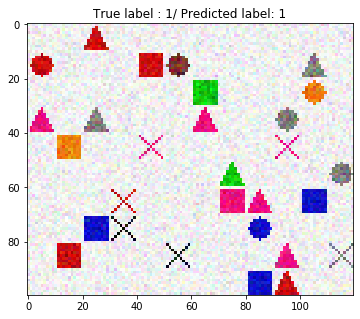

In [55]:
#@title
image1 = images[1]
label1 = labels[1]

im1 = image1.view(-1, 3, 100, 120)
outputs = net(im1)
_, predicted1 = torch.max(outputs.data, 1)

display_image(image1, label1, int(predicted1))

This image was correctly labeled as a 1, because it contains a red triangle.

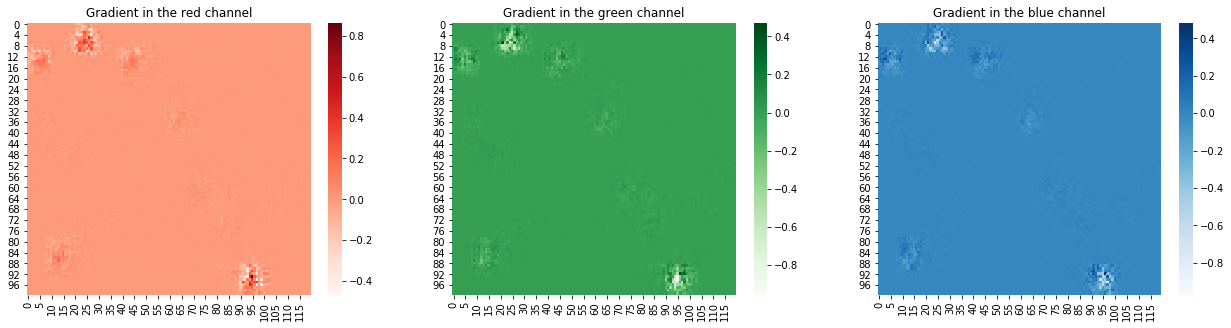

In [56]:
#@title
im1.requires_grad = True # Necessary to compute the gradient
gradients1 = backprop.calculate_gradients(im1, label1)

fig = plt.figure(figsize = (3*FIGSIZE[0]*1.2, FIGSIZE[1]))
ax1 = fig.add_subplot(131, title = "Gradient in the red channel")
ax2 = fig.add_subplot(132, title = "Gradient in the green channel")
ax3 = fig.add_subplot(133, title = "Gradient in the blue channel")
_ = sns.heatmap(gradients1.detach().numpy()[0], cmap="Reds", ax = ax1)
_ = sns.heatmap(gradients1.detach().numpy()[1], cmap="Greens", ax = ax2)
_ = sns.heatmap(gradients1.detach().numpy()[2], cmap="Blues", ax = ax3)

The model correctly spots the trianlges. The importance is highest in the red channel. 

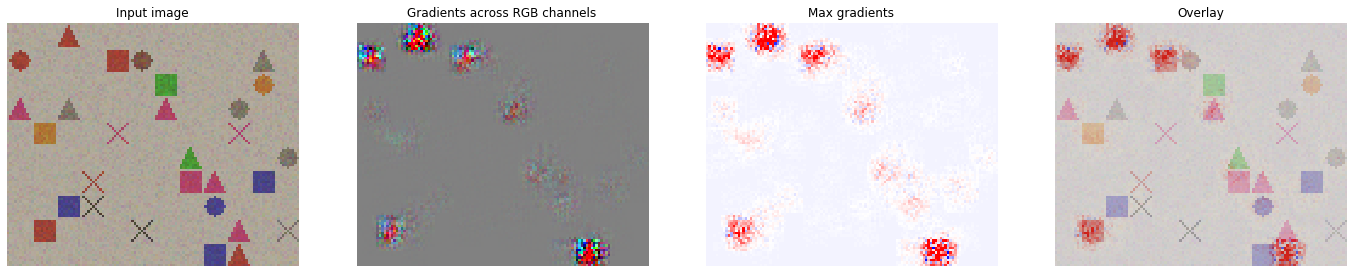

In [57]:
#@title
backprop.visualize(im1, label1, guided=True, figsize = (4*FIGSIZE[0], FIGSIZE[1]), cmap = 'bwr')

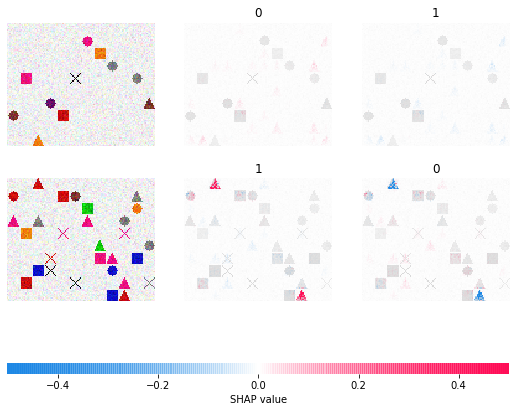

In [58]:
#@title
data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/3000/data3/noisy.zip", 'r')

bg_choice = None # Default: entire training set, "average", "white", "black" 
# Median would result in white 

root_dir = "main_dir"
data.extractall(root_dir)
data.close()

train_data = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transf)
dataloader = DataLoader(train_data, batch_size = len(train_data), shuffle = True, num_workers = 0)

train_loader = iter(dataloader)
X,Y = next(train_loader)
background = X

if (bg_choice == "black"): 
  background = -torch.ones(X.shape)
elif (bg_choice == "white"): 
  background = torch.ones(X.shape)
elif (bg_choice == "average"): 
  avg = torch.mean(X, dim = 0)
  display_image(avg, 0)
  background = avg.unsqueeze(0)

to_explain = images

e = shap.GradientExplainer(net, background)

shap_values,indexes = e.shap_values(to_explain, ranked_outputs=2, nsamples=100)

shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]


to_explain = np.swapaxes(np.swapaxes(to_explain,1,2),2,3)



mean = np.array([0.5, 0.5, 0.5])
sd = np.array([0.5, 0.5, 0.5])
images_plot = 255*(to_explain.numpy()*0.5 + 0.5)


shap.image_plot(shap_values, images_plot, indexes.numpy())

k = 0


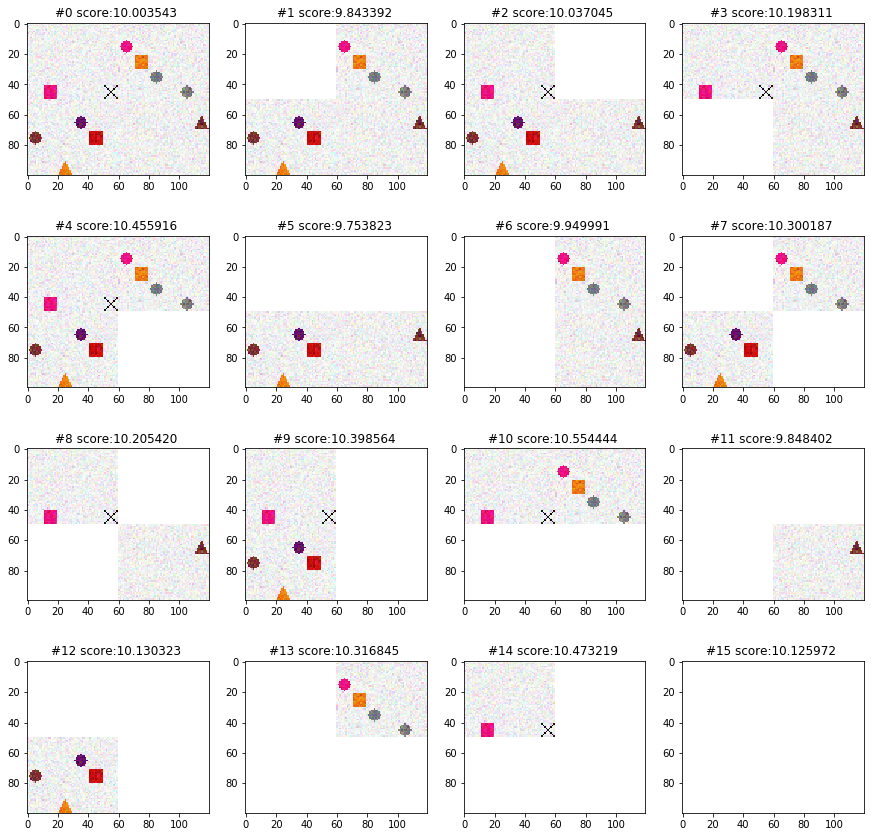

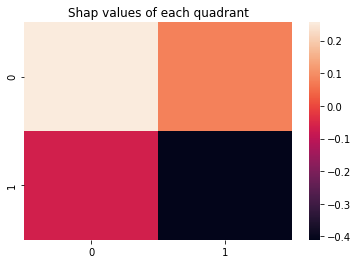

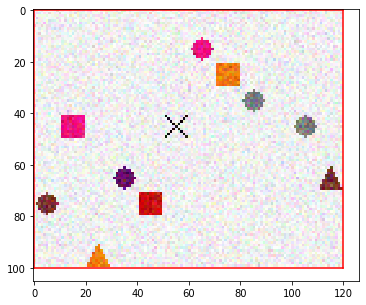

In [169]:
#@title
data = iter(dataloader)
images, labels = next(data)


def display_cropped_images(images, score): 
  mean = np.array([0.5, 0.5, 0.5])
  sd = np.array([0.5, 0.5, 0.5])
  fig, axs = plt.subplots(4,4, figsize=(15,15))
  for i in range(4):
    for j in range(4): 
      sample_image = images[4*i + j].numpy().transpose(1,2,0)
      im = sample_image*sd + mean
      axs[i,j].imshow(im)
      axs[i,j].set_title("#%d score:%f " %(4*i + j, score[4*i + j]))

def construct_subsets(im, label, start = (0,0), region_size = (None, None), background = None): 
  if (region_size[0] == None or region_size[1] == None):
    region_size = im.numpy().shape[1:3]

  middle = (start[0] + int(0.5*region_size[0]), start[1] + int(0.5*region_size[1]))
  end = (start[0] + region_size[0], start[1] + region_size[1])
  
  subsets_size = [16]
  image_size = []
  for dim in im.shape: 
    subsets_size.append(dim)
    image_size.append(dim)
  subsets = torch.zeros(subsets_size)

  quadrant_size = [image_size[0], int(region_size[0]/2), int(region_size[1]/2)]
  if (background == None): 
    background = torch.ones(image_size)


  # removing 0 features 
  im1234 = background.clone()
  im1234[:,start[0]:end[0],start[1]:end[1]] = im[:,start[0]:end[0],start[1]:end[1]]
  # removing 1 feature
  im234 = im1234.clone()
  im234[:,start[0]:middle[0],start[1]:middle[1]] = background[:,start[0]:middle[0],start[1]:middle[1]]
  im134 = im1234.clone()
  im134[:,start[0]:middle[0],middle[1]:end[1]] = background[:,start[0]:middle[0],middle[1]:end[1]]
  im124 = im1234.clone()
  im124[:,middle[0]:end[0],start[1]:middle[1]] = background[:,middle[0]:end[0],start[1]:middle[1]]
  im123 = im1234.clone()
  im123[:,middle[0]:end[0],middle[1]:end[1]] = background[:,middle[0]:end[0],middle[1]:end[1]]
  # removing 2 features
  im34 = im234.clone()
  im34[:,start[0]:middle[0],middle[1]:end[1]] = background[:,start[0]:middle[0],middle[1]:end[1]]
  im24 = im234.clone()
  im24[:,middle[0]:end[0],start[1]:middle[1]] = background[:,middle[0]:end[0],start[1]:middle[1]]
  im23 = im234.clone()
  im23[:,middle[0]:end[0],middle[1]:end[1]] = background[:,middle[0]:end[0],middle[1]:end[1]]
  im14 = im134.clone()
  im14[:,middle[0]:end[0],start[1]:middle[1]] = background[:,middle[0]:end[0],start[1]:middle[1]]
  im13 = im134.clone()
  im13[:,middle[0]:end[0],middle[1]:end[1]] = background[:,middle[0]:end[0],middle[1]:end[1]]
  im12 = im123.clone()
  im12[:,middle[0]:end[0],start[1]:middle[1]] = background[:,middle[0]:end[0],start[1]:middle[1]]
  # remoing 3 features 
  im4 = im34.clone()
  im4[:,middle[0]:end[0],start[1]:middle[1]] = background[:,middle[0]:end[0],start[1]:middle[1]]
  im3 = im34.clone()
  im3[:,middle[0]:end[0],middle[1]:end[1]] = background[:,middle[0]:end[0],middle[1]:end[1]]
  im2 = im24.clone()
  im2[:,middle[0]:end[0],middle[1]:end[1]] = background[:,middle[0]:end[0],middle[1]:end[1]]
  im1 = im14.clone()
  im1[:,middle[0]:end[0],middle[1]:end[1]] = background[:,middle[0]:end[0],middle[1]:end[1]]
  # removing 4 
  im_ = background
  
  subsets[0] = im1234
  subsets[1] = im234
  subsets[2] = im134
  subsets[3] = im124
  subsets[4] = im123
  subsets[5] = im34
  subsets[6] = im24
  subsets[7] = im23
  subsets[8] = im14
  subsets[9] = im13
  subsets[10] = im12
  subsets[11] = im4
  subsets[12] = im3
  subsets[13] = im2
  subsets[14] = im1
  subsets[15] = im_

  outputs = net(subsets)
  
  score = np.zeros(16)
  score[0] = outputs[0,label]
  score[1] = outputs[1,label]
  score[2] = outputs[2,label]
  score[3] = outputs[3,label]
  score[4] = outputs[4,label]
  score[5] = outputs[5,label]
  score[6] = outputs[6,label]
  score[7] = outputs[7,label]
  score[8] = outputs[8,label]
  score[9] = outputs[9,label]
  score[10] = outputs[10,label]
  score[11] = outputs[11,label]
  score[12] = outputs[12,label]
  score[13] = outputs[13,label]
  score[14] = outputs[14,label]
  score[15] = outputs[15,label]
  return subsets, score

def constructShapMap(score):
  phi1 = (score[14]-score[15])/4 + (score[8]-score[11] + score[9]-score[12] + score[10]-score[13])/12 + (score[2]-score[5] + score[3]-score[6] + score[4]-score[7])/12 + (score[0]-score[1])/4
  phi2 = (score[13]-score[15])/4 + (score[6]-score[11] + score[7]-score[12] + score[10]-score[14])/12 + (score[1]-score[5] + score[3]-score[8] + score[4]-score[9])/12 + (score[0]-score[2])/4
  phi3 = (score[12]-score[15])/4 + (score[5]-score[11] + score[9]-score[12] + score[7]-score[13])/12 + (score[2]-score[8] + score[1]-score[6] + score[4]-score[10])/12 + (score[0]-score[3])/4
  phi4 = (score[11]-score[15])/4 + (score[6]-score[14] + score[5]-score[12] + score[6]-score[13])/12 + (score[1]-score[9] + score[3]-score[10] + score[1]-score[9])/12 + (score[0]-score[4])/4
  shap_map = np.array([[phi1, phi2], [phi3, phi4]])
  return shap_map

def get_salient_regions(image, shap_map,  start, quadrant_size): 
  srs = []
  for i in range(len(shap_map)): 
    for j in range(len(shap_map)): 
      if (shap_map[i,j] > 8): 
        print(i,j)
        x = start[0] + i*quadrant_size[0]
        y = start[1] + j*quadrant_size[1]
        srs.append( ((x,y),(quadrant_size)) )
  return srs
def display_salient(im, srs):
  plt.figure(figsize = FIGSIZE)
  sample_image = im.numpy().transpose(1,2,0)
  mean = np.array([0.5, 0.5, 0.5])
  sd = np.array([0.5, 0.5, 0.5])
  image = sample_image*sd + mean
  N_points = 101
  plt.imshow(image)
  for sr in srs:
    start = sr[0]
    quadrant_size = sr[1]
    plt.plot(np.linspace(start[1], start[1]+quadrant_size[1], N_points), start[0]*np.ones(N_points), 'r')
    plt.plot(np.linspace(start[1], start[1]+quadrant_size[1], N_points), (start[0]+quadrant_size[0])*np.ones(N_points), 'r')
    plt.plot(start[1]*np.ones(N_points), np.linspace(start[0], start[0]+quadrant_size[0], N_points), 'r')
    plt.plot((start[1]+quadrant_size[1])*np.ones(N_points), np.linspace(start[0], start[0]+quadrant_size[0], N_points), 'r')

import seaborn as sns
def do_all(im, label, strt, rgs):
  images_final, score = construct_subsets(im, label, strt, rgs) 
  display_cropped_images(images_final, score) 

  sm = constructShapMap(score)

  f = plt.figure()
  sns.heatmap(sm)
  plt.title("Shap values of each quadrant");
  quad = (int(rgs[0]/2), int(rgs[1]/2))
  srs = get_salient_regions(im, sm, strt, quad)
  return srs

srs = [((0,0),(100,120))]
finished = []
k = 0
while (len(srs) > 0):
  print('k = %d' %k)
  all = []
  for sr in srs: 
    s = do_all(image0, label0, sr[0], sr[1])
    if (s == []):
      finished .append(((sr[0]), (sr[1])))
    else:
      all += s
  srs = all
  k += 1
display_salient(image0, finished)

In [163]:
print(finished)

[(87, 90), (12, 15), (0, 22), (6, 7), (6, 22), (6, 7)]
